<a href="https://colab.research.google.com/github/ioannis-toumpoglou/pytorch-repo/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Custom Datasets

## Domain Libraries

Depending on the problem, whether it is vision, text, audio or recommendation, look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

## 0. Importing PyTorch and setting up device-agnostic code

In [195]:
import torch
from torch import nn

# Note: PyTorch 1.10.0 and above is required
torch.__version__

'2.0.1+cu118'

In [196]:
# Setup device-agnostic device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get data

The dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing)

This dataset starts with 3 classes and only 10% of the images (~75 training, 25 testing).


Why?


When starting a ML project, it is important to try things out on a small scale and then gradually increase the scale, when necessary.

The whole point is to speed up how fast you can experiment.

In [197]:
import requests
import zipfile
from pathlib import Path

# Setup a path to a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
  print(f'{image_path} directory already exists... Skipping download')
else:
  print(f'{image_path} directory doesn\'t exist... Creating directory')
  image_path.mkdir(parents=True,
                   exist_ok=True)
  
# Download data
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as file:
  request = requests.get(url='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
  print(f'Downloading the dataset...')
  file.write(request.content)

# Unzip the downloaded file
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
  print('Unzipping the dataset file...')
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists... Skipping download
Unzipping the dataset file...


## 2. Becoming one with the data (data preparation and exploration)

In [198]:
import os

def walk_through_dir(dir_path):
  """
    Walks through dir_path returning its contents.
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.')

In [199]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi.
There are 3 directories and 0 images in data/pizza_steak_sushi/test.
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza.
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi.
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak.
There are 3 directories and 0 images in data/pizza_steak_sushi/train.
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza.
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi.
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak.


In [200]:
# Setup training and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

Write code to:
1. Get all image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name
4. Open the image with Python PIL
5. Show image and print metadata

Random image path: data/pizza_steak_sushi/train/steak/1976160.jpg
Image class: steak
Image height: 512
Image width: 512


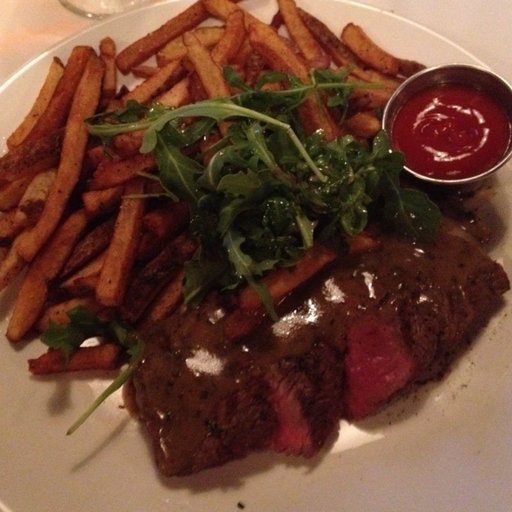

In [201]:
import random
from PIL import Image

# Set seed
torch.manual_seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get the image class name
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Show image and print metadata
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')

img

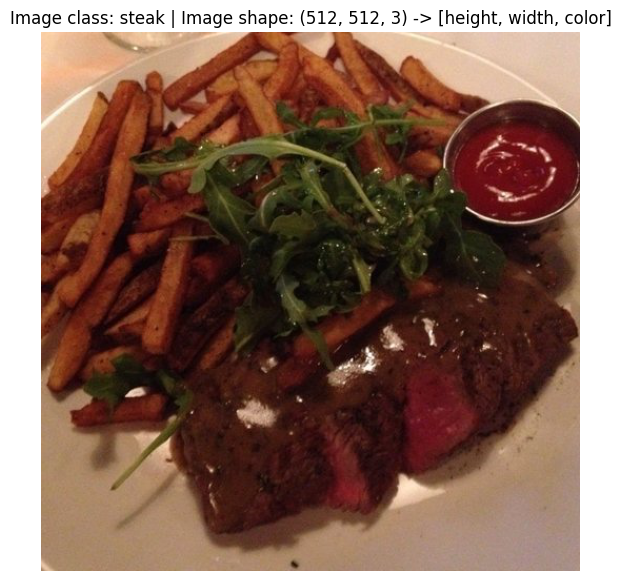

In [202]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color]')
plt.axis(False);

In [203]:
img_as_array

array([[[252, 209, 167],
        [250, 207, 165],
        [248, 205, 163],
        ...,
        [222, 195, 178],
        [225, 198, 181],
        [230, 203, 186]],

       [[251, 208, 166],
        [250, 207, 165],
        [248, 205, 163],
        ...,
        [226, 199, 182],
        [226, 199, 180],
        [227, 200, 181]],

       [[250, 207, 165],
        [249, 206, 164],
        [249, 206, 164],
        ...,
        [229, 202, 183],
        [227, 200, 181],
        [225, 198, 179]],

       ...,

       [[180, 145, 115],
        [195, 160, 130],
        [211, 176, 146],
        ...,
        [175, 149, 136],
        [174, 148, 133],
        [168, 142, 127]],

       [[171, 136, 106],
        [180, 145, 115],
        [195, 160, 130],
        ...,
        [175, 149, 136],
        [174, 148, 133],
        [172, 146, 131]],

       [[169, 134, 104],
        [172, 137, 107],
        [183, 148, 118],
        ...,
        [175, 149, 136],
        [174, 148, 133],
        [176, 150, 135]]

## 3. Transforming data

Before using an image with PyTorch:
1. Turn the target data into tensors
2. Turn the target data into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`

In [204]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms helps getting the images ready to be used with a model/platform data augmentation

In [205]:
# Write a transform form image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=[64, 64]),
    # Flip the images randomly on the horizontal axis
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a tensor
    transforms.ToTensor()
])

In [206]:
data_transform(img)

tensor([[[0.9804, 0.9725, 0.9490,  ..., 0.8824, 0.8784, 0.8824],
         [0.9725, 0.9569, 0.9294,  ..., 0.8784, 0.8824, 0.8863],
         [0.9608, 0.9451, 0.9294,  ..., 0.8824, 0.8863, 0.8824],
         ...,
         [0.6588, 0.6588, 0.6588,  ..., 0.6588, 0.6627, 0.6706],
         [0.6980, 0.6627, 0.6627,  ..., 0.6588, 0.6627, 0.6667],
         [0.8039, 0.7020, 0.6627,  ..., 0.6588, 0.6549, 0.6706]],

        [[0.8118, 0.8000, 0.7608,  ..., 0.7686, 0.7725, 0.7765],
         [0.8039, 0.7843, 0.7490,  ..., 0.7686, 0.7686, 0.7725],
         [0.8000, 0.7765, 0.7529,  ..., 0.7686, 0.7686, 0.7725],
         ...,
         [0.5255, 0.5255, 0.5294,  ..., 0.5608, 0.5608, 0.5569],
         [0.5608, 0.5333, 0.5294,  ..., 0.5608, 0.5608, 0.5608],
         [0.6706, 0.5725, 0.5333,  ..., 0.5608, 0.5608, 0.5686]],

        [[0.6471, 0.6431, 0.6118,  ..., 0.6980, 0.7020, 0.6980],
         [0.6471, 0.6235, 0.6039,  ..., 0.6980, 0.7020, 0.6980],
         [0.6510, 0.6314, 0.6078,  ..., 0.6863, 0.6980, 0.

In [207]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [208]:
data_transform(img).dtype

torch.float32

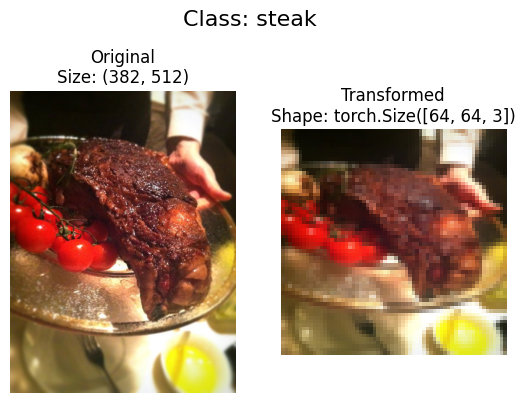

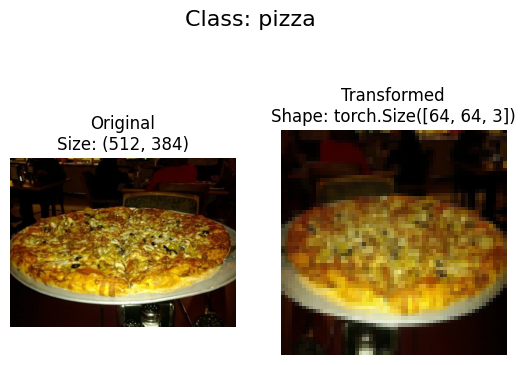

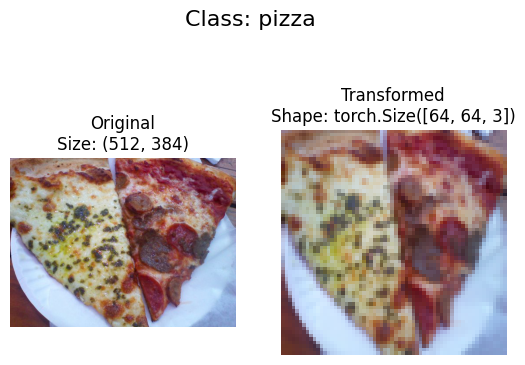

In [209]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """
    Selects random images, loads/transforms them and plots the original vs transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, axis = plt.subplots(nrows=1, ncols=2)
      axis[0].imshow(f)
      axis[0].set_title(f'Original\nSize: {f.size}')
      axis[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0)  # need to change shape for matplotlib (C, H , W) -> (H, W, C)
      axis[1].imshow(transformed_image)
      axis[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
      axis[1].axis('off')

      fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)


plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## 4. Option 1: Loading image data using `ImageFolder`

Image classification data can be loaded using `torchvision.datasets.ImageFolder`

In [210]:
# Use ImageFolder to create datasets
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,   # a transform for the data
                                  target_transform=None)    # a teansform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [211]:
# Get class names as a list
class_names = train_data.class_to_idx
class_names

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [212]:
len(train_data), len(test_data)

(225, 75)

In [213]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [214]:
# Index on the train_data dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f'Image tensor: {img}')
print(f'Image shape: {img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'Image label: {label}')
print(f'Label datatype: {type(label)}')

Image tensor: tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color]


Text(0.5, 1.0, 'pizza')

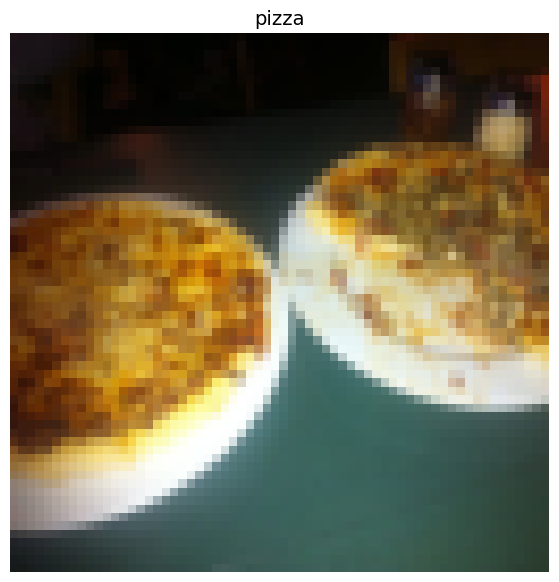

In [215]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f'Original shape: {img.shape} -> [color, height, width]')
print(f'Image permute: {img_permute.shape} -> [height, width, color]')

# Plot image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis('off')
res = dict((v,k) for k,v in class_names.items())
plt.title(res[label], fontsize=14)

### 4.1 Turn loaded images into data loaders

A `DataLoader` is going to help turn a `Dataset` into an iterable 

In [216]:
import os
os.cpu_count()

2

In [217]:
# Turn train and test datasets into DataLoaders
from torch.utils.data import DataLoader

BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7faceab72050>,
 <torch.utils.data.dataloader.DataLoader at 0x7faceab70e80>)

In [218]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [219]:
len(train_data), len(test_data)

(225, 75)

In [220]:
img, label = next(iter(train_dataloader))

print(f'Image shape: {img.shape} -> [batch_size, color, height, width]')
print(f'Label shape: {label.shape}')

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading image data with a custom dataset

1. Load images from file
2. Get class names from the dataset
3. Get classes as dictionary from the 

Pros:
* Create a dataset out of almost anything
* Not limited to PyTorch pre-built dataset functions

Cons:
* Creating a dataset out of almost anything doesn't mean it will work
* Using a custom dataset often results in writing more code, prone to errors or performance issues

In [221]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [222]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

The function will:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally this directory is in standard image classification format)
2. Raise an error if the class names not found
3. Turn the class names into a dict and a list and return them

In [223]:
# Setup the path directory
target_directory = train_dir
print(f'Target dir: {target_directory}')

# Get the class names
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [224]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """
    Finds the class folder names in a target directory.
  """
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise error if class names not found
  if not classes:
    raise FileNotFoundError(f'Unable to find any classes in {directory}.. Please check file structure.')

  # 3. Create a dictionary of index labels
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [225]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate ImageFolder

To create a custom dataset:

1. Subclass `torch.utils.data.Dataset`
2. Init the subclass with a target directory as well as a transform, if the data need to transform
3. Create several attributes
  * paths - paths of images
  * transform - the transform to be used
  * classes - a list of target classes
  * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to load the images
5. Override the `__len()__` method to return the length of the dataset
6. Override the `__getitem()__` method to return a given sample when an index is passed

In [226]:
# Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Init custom dataset
  def __init__(self, targ_dir: str, transform=None):
    # 3. Create class attributes
    # Get all image paths
    self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
    # Setup transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)
  
  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Override __len__()
  def __len__(self) -> int:
    "Returns the total number of samples"
    return len(self.paths)

  # 6. Override __getitem__()
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns a sample of data, data and label (X, y)"
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]
    
    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [227]:
# Create a transform
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [228]:
# Test ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [229]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7facea7d3cd0>,
 <__main__.ImageFolderCustom at 0x7facea7d1450>)

In [230]:
len(train_data), len(train_data_custom)

(225, 225)

In [231]:
len(test_data), len(test_data_custom)

(75, 75)

In [232]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [233]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [234]:
# Check for equality between original ImageFolder and ImageFolderCustom datasets
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters, such as class names and the number of images
2. To prevent the display from getting out of hand, limit the number of images to 10
3. Set the random seed
4. Get a list of random sample indexes from the target dataset
5. Setup a matplotlib plot
6. Loop through the random indexes and plot them
7. Make sure the images' dimensions line up with matplotlib (HWC)

In [235]:
# 1. Create a function to take a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Limit the number of images
  if n > 10:
    n = 10
    display_shape = False
    print(f'For display purposes, n shouldn not be larger than 10. \nSetting to 10 and removing shape display.')
  
  # 3. Set the seed
  if seed:
    random.seed(seed)
  
  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through the random indexes and plot the
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
    
    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0)   # [c, h, w] -> [h, w, c]
    
    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis('off')

    if classes:
      res = dict((v,k) for k,v in class_names.items())
      title = f'Class: {res[targ_label]}'
      if display_shape:
        title = title + f'\nshape: {targ_image_adjust.shape}'
    plt.title(title)

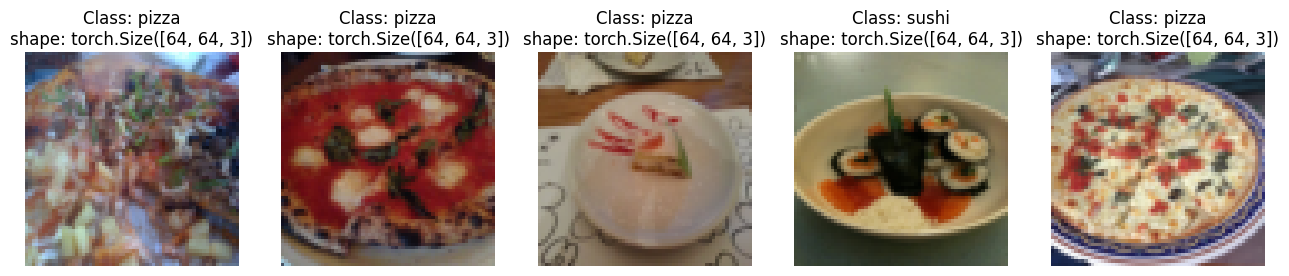

In [236]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

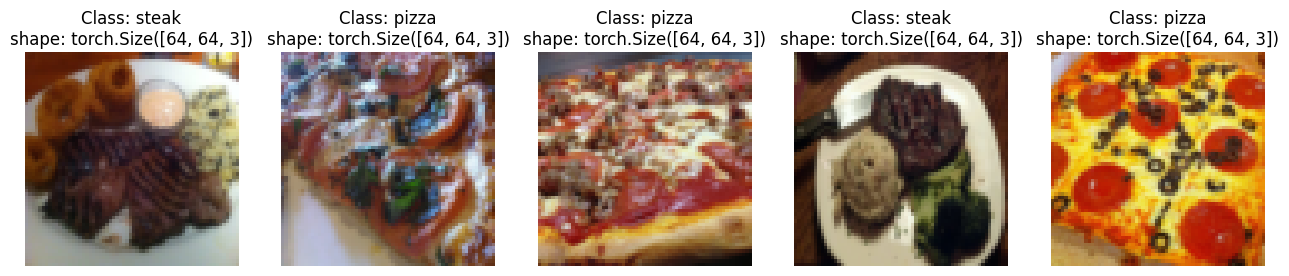

In [238]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=42)

### 5.4 Turn custom loaded images to `DataLoader`s

In [239]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7face2b46350>,
 <torch.utils.data.dataloader.DataLoader at 0x7face2b47280>)

In [240]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))